In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import numpy as np

In [2]:
df = pd.read_pickle('../results/results.pkl')

In [42]:
def get_rows(
    args_dict,
):
    idx = {}
    for key, value in args_dict.items():
        if value is None:
            idx[key] = np.ones_like(df[key], dtype=bool)
        else:
            idx[key] = df[key] == value
        
    run_idx = np.ones_like(df['test_loss'], dtype=bool)
    for key, value in idx.items():
        run_idx = run_idx & value
    
    # print(f"Selected {run_idx.sum()} runs!")
    
    run_df = df[run_idx].reset_index(drop=True) 
    return run_df

def get_loss(
    args_dict,
):
    run_df = get_rows(args_dict)

    rank_set = np.unique(run_df['rank'])
    seed_set = np.unique(run_df['seed'])
    test_loss, test_loss_mean, test_loss_std = {}, {}, {}
    
    for tune_bias in [0,1]:
        test_loss_mean[tune_bias], test_loss_std[tune_bias], test_loss[tune_bias] = {}, {}, {}
        group_df = run_df[run_df['tune_bias'] == tune_bias].reset_index(drop=True)        
        for rank in rank_set:
            rank_df = group_df[group_df['rank'] == rank].reset_index(drop=True)
            test_loss[tune_bias][rank] = {}
            for seed in seed_set:
                seed_df = rank_df[rank_df['seed'] == seed].reset_index(drop=True)  
                if len(seed_df):
                    test_loss[tune_bias][rank][seed] = seed_df['test_loss'].iloc[0]
                else: 
                    test_loss[tune_bias][rank][seed] = np.inf
                    
            num_params = rank*2*width*frozen_depth
            if tune_bias:
                num_params += width*frozen_depth

            test_loss_mean[tune_bias][num_params] = pd.Series(test_loss[tune_bias][rank]).median()
            test_loss_std[tune_bias][num_params] = pd.Series(test_loss[tune_bias][rank]).std()
    return test_loss_mean

## FNN Approximation

In [43]:
activation = 'relu'
width = 16
exp = 'fnn'
init_mode = 'default'
target_depth = 1
frozen_depth = 2
fnn_results = {}

for pretrained in [0,1]:
    fnn_results[pretrained] = get_loss({
    'activation': activation,
    'target_depth': target_depth,
    'frozen_depth': frozen_depth,
    'init_mode': init_mode,
    'width': width,
    'exp': exp,
    'pretrained': pretrained,
})
    

In [44]:
fnn_results[0]

{0: {0: 0.16716726124286652,
  64: 0.10881733149290083,
  128: 0.10015495121479034,
  192: 0.08785765618085861,
  256: 0.05783192068338394,
  320: 0.05105755478143692,
  384: 0.06099386513233185,
  448: 0.07276032865047455,
  512: 0.013735844753682612,
  576: 0.02232726663351059,
  640: 0.021338356658816338,
  704: 0.06549836695194244,
  768: 0.065024733543396,
  832: 0.018474234268069267,
  896: 0.02221517078578472,
  960: 0.05939178541302681,
  1024: 0.01974906586110592},
 1: {32: inf,
  96: 0.10972966253757475,
  160: 0.06654862314462662,
  224: 0.035743482410907745,
  288: 0.018372060731053352,
  352: 0.00816460233181715,
  416: 0.0020958292298018932,
  480: 0.0002423161931801587,
  544: 4.5796386127783246e-10,
  608: 3.6641392697767117e-10,
  672: 2.6483026882573313e-10,
  736: 3.339410414859856e-10,
  800: 4.6409577569850313e-11,
  864: 3.5718872304357774e-11,
  928: 2.551567984676595e-11,
  992: 1.8880137037102784e-11,
  1056: 1.2102438842753747e-11}}

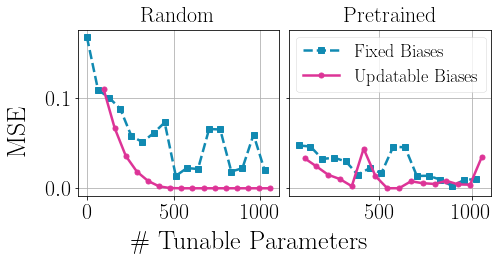

In [45]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend


sgd_marker, sgd_color, sgd_lt, sgd_ms = 's', '#118AB2', '--', 6
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.98, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for pretrained in [0,1]:
    pd.Series(fnn_results[pretrained][0]).plot(ax = ax[pretrained], color = sgd_color, label = 'Fixed Biases', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
    pd.Series(fnn_results[pretrained][1]).plot(ax = ax[pretrained], color = our_color, label = 'Updatable Biases', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)
    ax[pretrained].grid(True)

ax[0].set_title('Random', size = 22, y = 1.01)
ax[1].set_title('Pretrained', size = 22, y = 1.01)

# ax[0].set_ylim(0,0.15)
ax[1].legend(fontsize=18, bbox_to_anchor=(1.02,1.01))
fig.supxlabel('\# Tunable Parameters', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)
    
plt.savefig('../figures/lora_bitfit_approx.pdf')
# Show the plot
plt.show()


In [ ]:
fnn_results